## Mod DOE
Scratch notebook for testing Ax and pyDOE modules

In [33]:
# !pip install ax-platform
# !pip install pyDOEg.add_subplot(1, 2, 2)
ind = -1

In [34]:
import pyDOE
import sys

from ax.service.ax_client import AxClient, ObjectiveProperties
from ax.utils.measurement.synthetic_functions import hartmann6
from ax.utils.notebook.plotting import init_notebook_plotting, render
import plotly.io as pio


import pickle
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import scienceplots

import os

import numpy as np
import pandas as pd

from Experiment_Utils import plot_dict_key
from utils import combine_meta_test

In [35]:
# dict_today = pickle.load(open('v2_test_dict.pkl', 'rb'))
dict_today = pickle.load(open('Taguchi_test_dict.pkl', 'rb'))

In [36]:
len(dict_today.keys())

16

In [37]:
# load in the design table to read in metadata values
design_df = pd.read_csv('Tag_d_params.csv')
design_df.columns

Index(['Design', 'material', 'lubricant', 'z_sh', 'z_r2', 'x_s', 'x_r2', 'Cl',
       'g_thickness_h', 'p1_offset', 'p2_offset', 'gear_ratio'],
      dtype='object')

In [38]:
tested_df = combine_meta_test(design_df,dict_today)

In [39]:
tested_df

,Design,material,lubricant,z_sh,z_r2,x_s,x_r2,Cl,g_thickness_h,p1_offset,p2_offset,gear_ratio,max_current,max_dxt
0,1,PLA,NaN,6,76,-0.8,-0.25,0.0000,3,-1,-1,5.359825e+01,1081.2500,0.964809
1,2,PLA,NaN,7,81,-0.5,0.00,0.0001,4,0,0,1.154805e+02,1157.5250,0.964809
2,3,PLA,NaN,8,83,0.0,0.50,0.0002,5,1,1,1.849580e+03,1166.2500,0.964809
3,4,PLA,NaN,9,85,0.5,1.00,0.0003,6,2,2,1.020000e+02,1197.5000,0.964809
4,5,PLA,LI,6,76,-0.5,0.00,0.0002,5,2,2,5.234387e+01,198.2000,0.181975
5,6,PLA,LI,7,81,-0.8,-0.25,0.0003,6,1,1,8.411060e+01,1127.8250,0.964809
6,7,PLA,LI,8,83,0.5,1.00,0.0000,3,0,0,2.749375e+02,1208.3500,0.964809
7,8,PLA,LI,9,85,0.0,0.50,0.0001,4,-1,-1,2.167500e+02,1201.2500,0.964809
8,9,PLA,Oil,6,81,0.0,1.00,0.0000,4,1,2,1.000000e+12,1272.1125,0.964809
9,10,PLA,Oil,7,76,0.5,0.50,0.0001,3,2,1,4.959073e+01,1226.2500,0.964809


In [40]:
add_vals =  [17,21,23,29]
for id_num in add_vals:
            max_current = np.nanmax(tested_df['max_current'])
            max_dxt = np.nanmax(tested_df['max_dxt'])
            
            tested_df.loc[tested_df['Design'] == float(id_num),'max_current'] = max_current
            tested_df.loc[tested_df['Design'] == float(id_num),'max_dxt'] = max_dxt

In [41]:
tested_df

,Design,material,lubricant,z_sh,z_r2,x_s,x_r2,Cl,g_thickness_h,p1_offset,p2_offset,gear_ratio,max_current,max_dxt
0,1,PLA,NaN,6,76,-0.8,-0.25,0.0000,3,-1,-1,5.359825e+01,1081.2500,0.964809
1,2,PLA,NaN,7,81,-0.5,0.00,0.0001,4,0,0,1.154805e+02,1157.5250,0.964809
2,3,PLA,NaN,8,83,0.0,0.50,0.0002,5,1,1,1.849580e+03,1166.2500,0.964809
3,4,PLA,NaN,9,85,0.5,1.00,0.0003,6,2,2,1.020000e+02,1197.5000,0.964809
4,5,PLA,LI,6,76,-0.5,0.00,0.0002,5,2,2,5.234387e+01,198.2000,0.181975
5,6,PLA,LI,7,81,-0.8,-0.25,0.0003,6,1,1,8.411060e+01,1127.8250,0.964809
6,7,PLA,LI,8,83,0.5,1.00,0.0000,3,0,0,2.749375e+02,1208.3500,0.964809
7,8,PLA,LI,9,85,0.0,0.50,0.0001,4,-1,-1,2.167500e+02,1201.2500,0.964809
8,9,PLA,Oil,6,81,0.0,1.00,0.0000,4,1,2,1.000000e+12,1272.1125,0.964809
9,10,PLA,Oil,7,76,0.5,0.50,0.0001,3,2,1,4.959073e+01,1226.2500,0.964809


In [42]:
tested_df.to_pickle('tested_df.pkl')

Taguchi_Design_1


c:\Users\campb\AppData\Local\Programs\Python\Python311\Lib\site-packages\mplcursors\_pick_info.py:56: UserWarning:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.



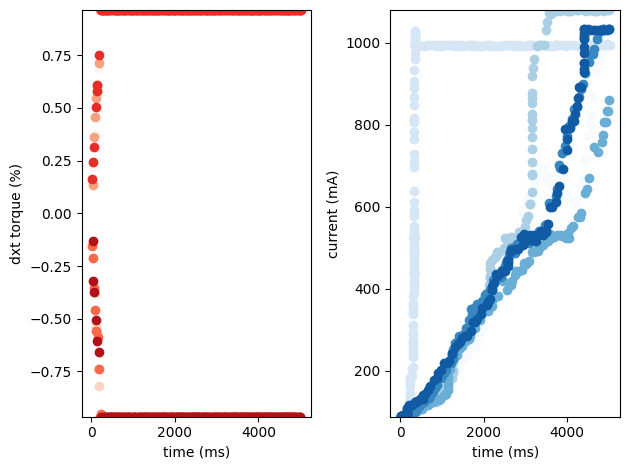

Taguchi_Design_2


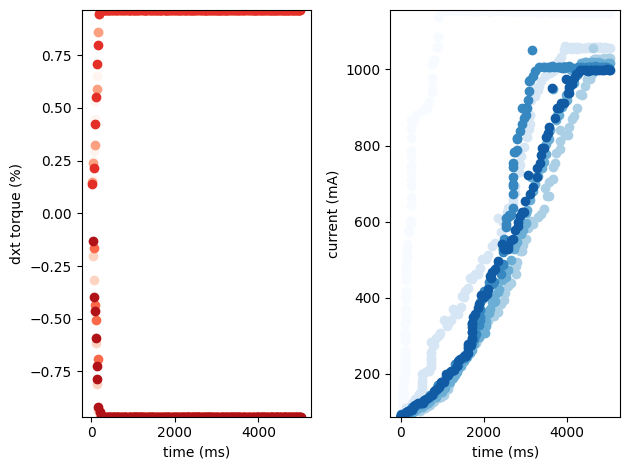

Taguchi_Design_3


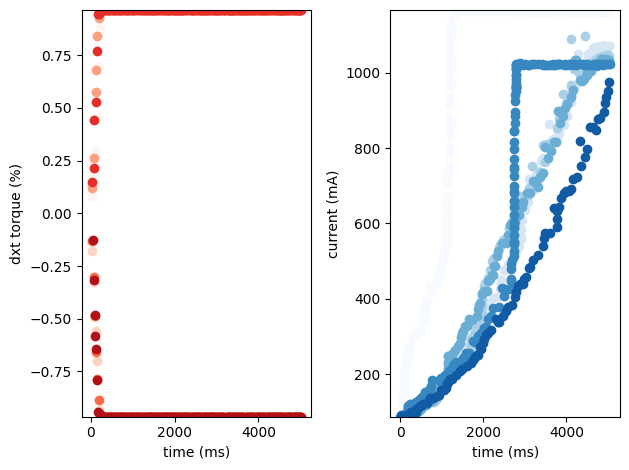

Taguchi_Design_4


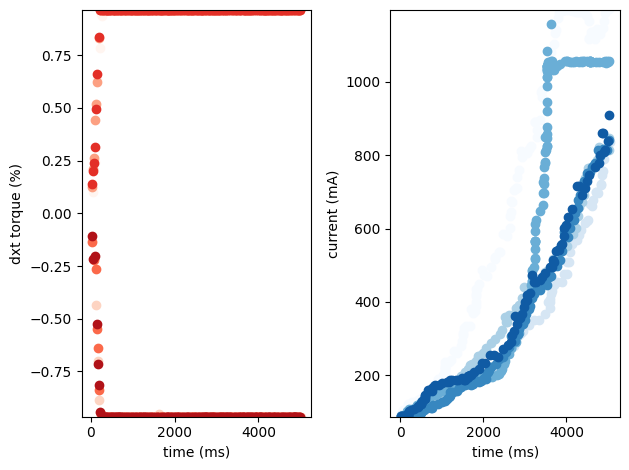

Taguchi_Design_5


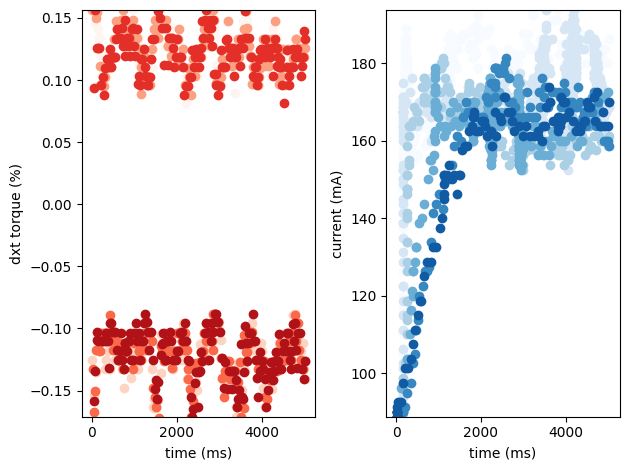

Taguchi_Design_6


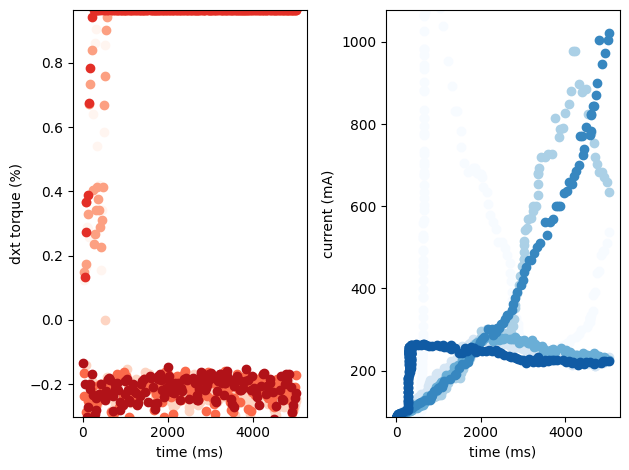

Taguchi_Design_7


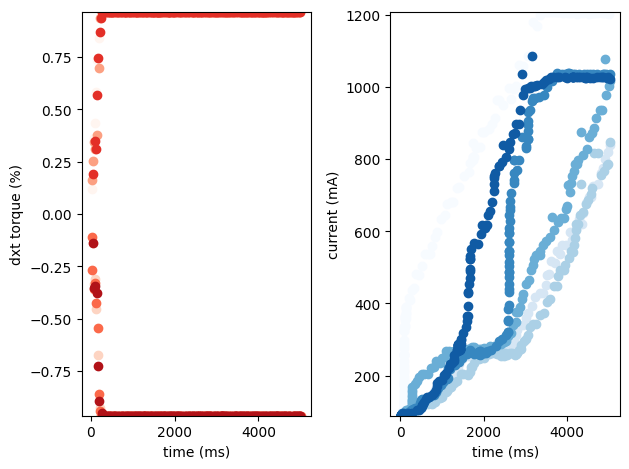

Taguchi_Design_8


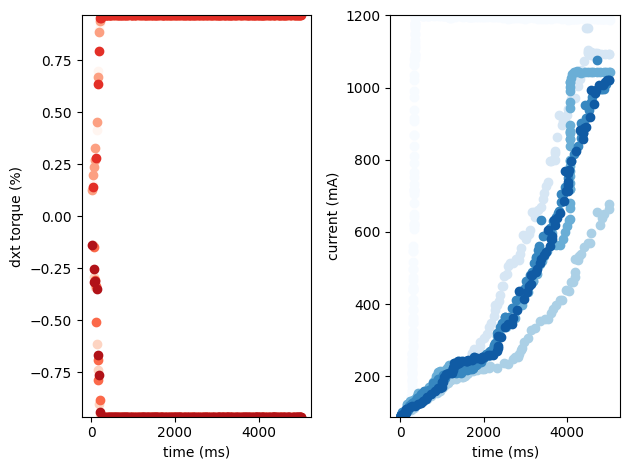

Taguchi_Design_9


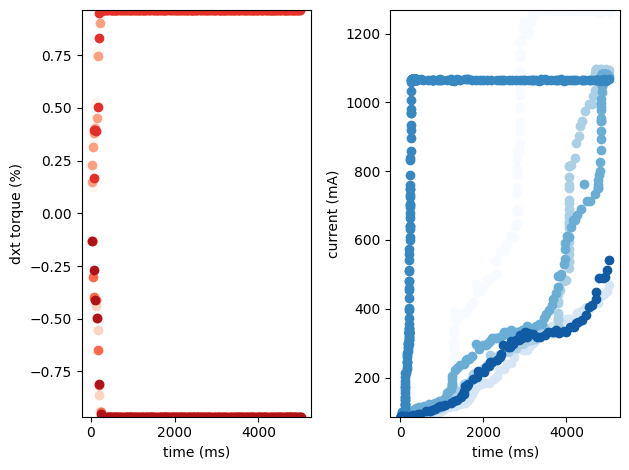

Taguchi_Design_10


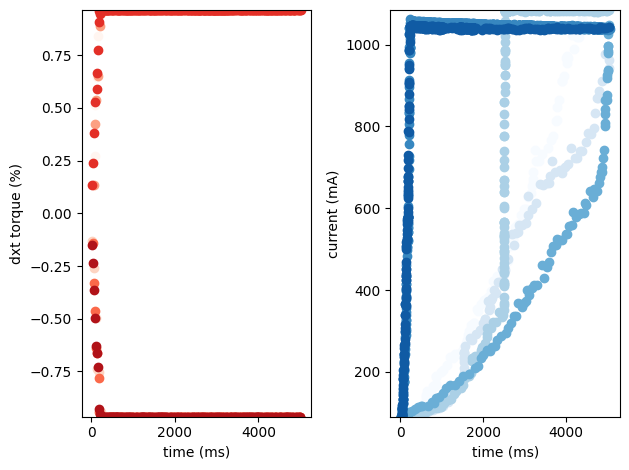

Taguchi_Design_11


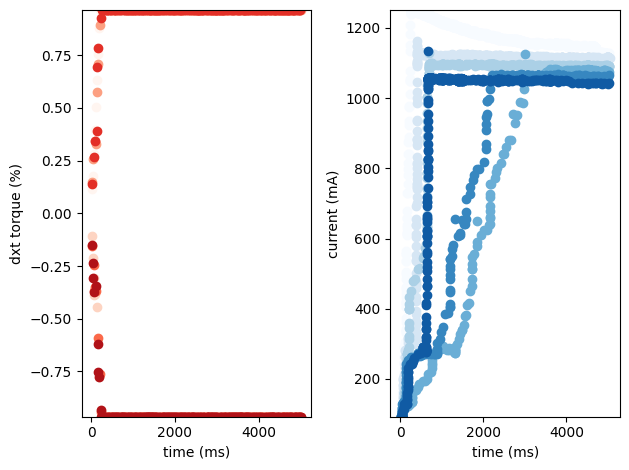

Taguchi_Design_12


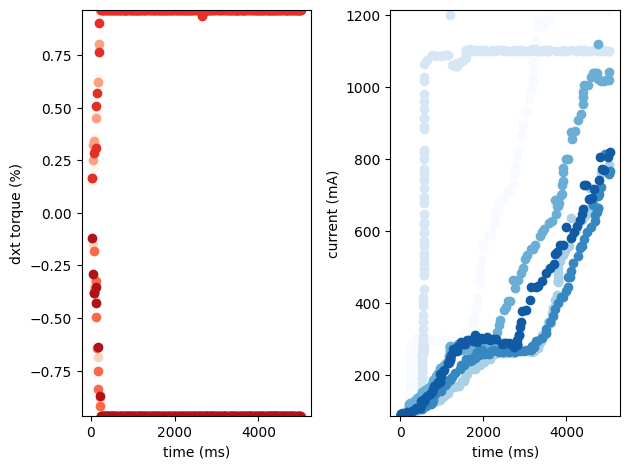

Taguchi_Design_13


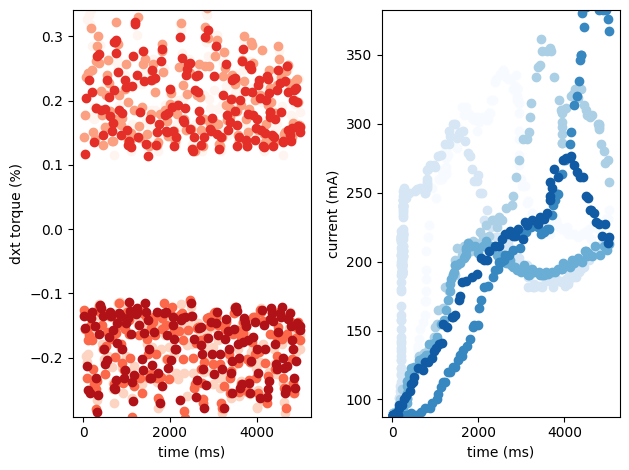

Taguchi_Design_14


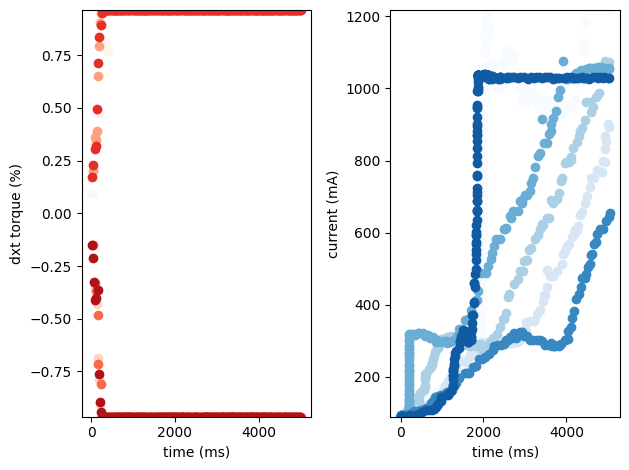

Taguchi_Design_15


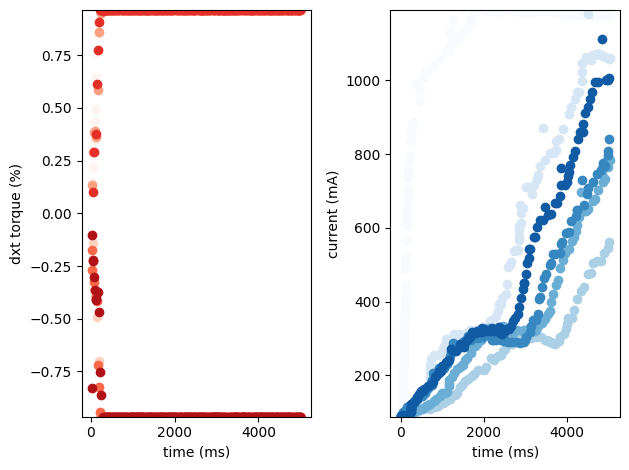

Taguchi_Design_16


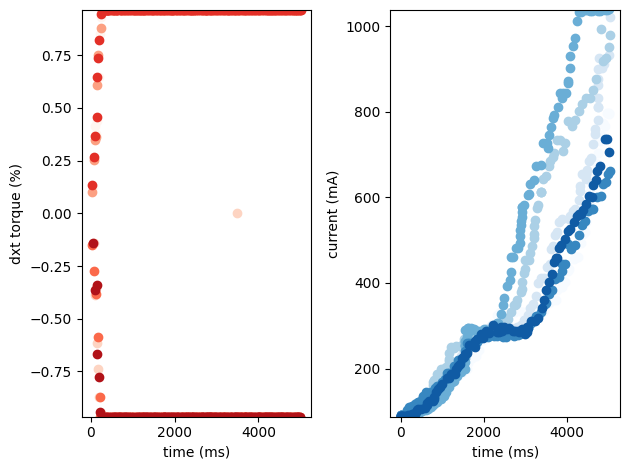

In [43]:
for key in dict_today.keys():
    print(key)
    plot_dict_key(dict_today, key)

In [44]:
file_dir = '/home/gmc/Python/Mod_DOE'
file_name = 'Taguchi_test_dict.pkl'

os.chdir(file_dir)
pickle.dump(combined_dict,open(file_name, 'wb'))

FileNotFoundError: [WinError 3] The system cannot find the path specified: '/home/gmc/Python/Mod_DOE'

In [ ]:
for key in dict_today.keys():
    print(key)
    length = len(dict_today[key])
    print(length)
    print(len(dict_today[key][length-1]))

test1
19
2


In [ ]:
len(dict_today[key][-1][1][-1])

58

In [ ]:
current_time = np.array(dict_today[key][-1][1][0])
current_vals = np.array(dict_today[key][-1][1][1])
dxt_time = np.array(dict_today[key][-1][0][0])
dxt_vals = np.array(dict_today[key][-1][0][1])

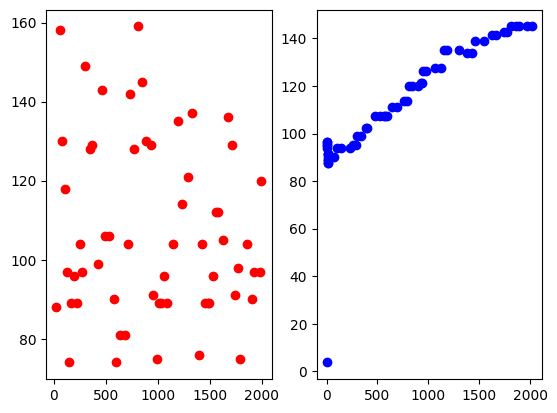

In [ ]:
# plot
fig = plt.figure()
# 2 subplots
ax = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ind = -1
ax.scatter(dxt_time, dxt_vals, c='r', label='torque')
ax2.scatter(current_time, current_vals, c='b', label='current')

plt.show()

In [ ]:
last_key = list(dict_today.keys())[-1]
print(dict_today[last_key][-1][:, 2])

fig = plt.figure()
# 2 subplots
ax = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ind = -1
ax.scatter(dict_today[last_key][ind][:, 0], dict_today[last_key][ind][:, 1], c='r', label='torque')
ax2.scatter(dict_today[last_key][ind][:, 0], dict_today[last_key][ind][:, 2], c='b', label='current')

plt.show()

TypeError: list indices must be integers or slices, not tuple

In [ ]:
key = dict_today.keys()
key = list(key)[0]

this_entry = dict_today[key]

concatted_entry = np.concatenate(this_entry, axis=0)

print(concatted_entry.shape)
# take max over 2nd column
# max_val = np.max(concatted_entry[:,2])


max = (np.max([float(i) for i in concatted_entry[:,1]])-1023)/1023
print(f'percent torque: {max:.3f}')

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 3 and the array at index 7 has size 93

In [ ]:
# force_entry = force_dict[keys[-1]]
# n = 3
# force_entry = [force_entry[0], force_entry[2], force_entry[3]]

In [ ]:
# force_dict[keys[-1]] = force_entry
# len(force_dict[keys[-1]])

In [ ]:
# pickle.dump(force_dict, open('3_12_force_dict.pkl', 'wb'))

In [ ]:
force_dict = pickle.load(open('3_12_force_dict.pkl', 'rb'))
keys = list(force_dict.keys())
len(force_dict[keys[-1]])


FileNotFoundError: [Errno 2] No such file or directory: '3_12_force_dict.pkl'

In [ ]:
force_entry = force_dict[keys[-1]][3:]
len(force_entry)
force_dict[keys[-1]] = force_entry

In [ ]:
len(force_dict[keys[-1]])

12

Text(0.5, 1.0, 'Force vs time')

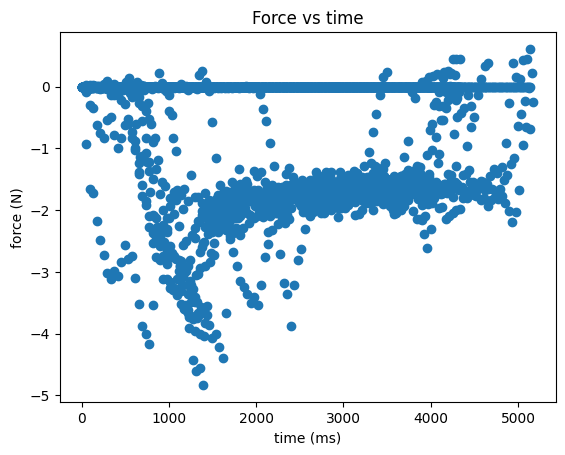

In [ ]:
force_entry = force_dict[keys[-1]]

force_entry = np.concatenate(force_entry, axis=0)

plt.scatter(force_entry[:,0], force_entry[:,1])
plt.xlabel('time (ms)')
plt.ylabel('force (N)')
plt.title('Force vs time')

In [ ]:
g = 9.81

for i in range(len(keys)):
    key = keys[i]
    print(f'Mass: {key}')
    mins = []
    for j in range(len(force_dict[key])):
        mins.append(np.min(force_dict[key][j]))
    static_force = np.median(mins)
    print(f'Min force: {static_force:.3f}N')
    mu = -static_force/(float(key[:-6])*g)
    print(f'Mu: {mu:.3f}')

Mass: 1.25kg_PLA_NonLubricated
Min force: -2.360N


ValueError: could not convert string to float: '1.25kg_PLA_NonLubr'

In [ ]:
# setup run on nvidia gpu
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

## Testing Ax on a simple tutorial case
https://ax.dev/docs/tutorials/gpei_hartmann_service

In [ ]:
ax_client = AxClient()

[INFO 03-07 10:03:51] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.


In [ ]:
ax_client.create_experiment(
    name="hartmann_test_experiment",
    parameters=[
        {
            "name": "x1",
            "type": "range",
            "bounds": [0.0, 1.0],
            "value_type": "float",  # Optional, defaults to inference from type of "bounds".
            "log_scale": False,  # Optional, defaults to False.
        },
        {
            "name": "x2",
            "type": "range",
            "bounds": [0.0, 1.0],
        },
        {
            "name": "x3",
            "type": "range",
            "bounds": [0.0, 1.0],
        },
        {
            "name": "x4",
            "type": "range",
            "bounds": [0.0, 1.0],
        },
        {
            "name": "x5",
            "type": "range",
            "bounds": [0.0, 1.0],
        },
        {
            "name": "x6",
            "type": "range",
            "bounds": [0.0, 1.0],
        },
    ],
    objectives={"hartmann6": ObjectiveProperties(minimize=True)},
    parameter_constraints=["x1 + x2 <= 2.0"],  # Optional.
    outcome_constraints=["l2norm <= 1.25"],  # Optional.
)

[INFO 03-07 10:03:51] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter x2. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 03-07 10:03:51] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter x3. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 03-07 10:03:51] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter x4. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 03-07 10:03:51] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter x5. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 03

In [ ]:
def evaluate(parameterization):
    x = np.array([parameterization.get(f"x{i+1}") for i in range(6)])
    # In our case, standard error is 0, since we are computing a synthetic function.
    return {"hartmann6": (hartmann6(x), 0.0), "l2norm": (np.sqrt((x**2).sum()), 0.0)}

In [ ]:
for i in range(1):
    parameterization, trial_index = ax_client.get_next_trial()
    # Local evaluation here can be replaced with deployment to external system.
    ax_client.complete_trial(trial_index=trial_index, raw_data=evaluate(parameterization))

/home/gmc/Python/.venv/lib/python3.12/site-packages/ax/modelbridge/cross_validation.py:439: UserWarning:

Encountered exception in computing model fit quality: RandomModelBridge does not support prediction.

[INFO 03-07 10:03:51] ax.service.ax_client: Generated new trial 0 with parameters {'x1': 0.345592, 'x2': 0.610833, 'x3': 0.987969, 'x4': 0.724378, 'x5': 0.936165, 'x6': 0.572914} using model Sobol.
[INFO 03-07 10:03:51] ax.service.ax_client: Completed trial 0 with data: {'hartmann6': (-0.025417, 0.0), 'l2norm': (np.float64(1.788293), 0.0)}.


In [ ]:
ax_client.generation_strategy.trials_as_df

/tmp/ipykernel_11585/1060711394.py:1: DeprecationWarning:

`GenerationStrategy.trials_as_df` is deprecated and will be removed in a future release. Please use `Experiment.to_df()` instead.



,trial_index,arm_name,trial_status,generation_method,generation_node,l2norm,hartmann6,x1,x2,x3,x4,x5,x6
0,0,0_0,COMPLETED,Sobol,GenerationStep_0,1.788293,-0.025417,0.345592,0.610833,0.987969,0.724378,0.936165,0.572914


In [ ]:
best_parameters, values = ax_client.get_best_parameters()
best_parameters

[ERROR 03-07 10:03:52] ax.service.utils.best_point: Encountered error while trying to identify the best point: No points satisfied all outcome constraints within 95 percentconfidence interval.


TypeError: cannot unpack non-iterable NoneType object

In [ ]:
render(ax_client.get_contour_plot())

[INFO 02-28 12:27:25] ax.service.ax_client: Retrieving contour plot with parameter 'x1' on X-axis and 'x2' on Y-axis, for metric 'hartmann6'. Remaining parameters are affixed to the middle of their range.


In [ ]:
render(ax_client.get_contour_plot(param_x="x3", param_y="x4", metric_name="l2norm"))

[INFO 02-28 12:27:25] ax.service.ax_client: Retrieving contour plot with parameter 'x3' on X-axis and 'x4' on Y-axis, for metric 'l2norm'. Remaining parameters are affixed to the middle of their range.


In [ ]:
render(
    ax_client.get_optimization_trace(objective_optimum=hartmann6.fmin)
)  # Objective_optimum is optional.

In [ ]:
print(trial_index)

24


In [ ]:
# optional save/load code
# file_name = "hartmann_test_experiment.json"
# ax_client.save_to_json_file(filepath=file_name)
# restored_ax_client = (
#     AxClient.load_from_json_file(filepath=file_name)
# )  # For custom filepath, pass `filepath` argument.

# Inputting personal dataset for optimization
Using data from height optimization

In [ ]:
# what is the datatype for the ax_client trial data?
print(type(ax_client.generation_strategy.trials_as_df))

<class 'pandas.core.frame.DataFrame'>


C:\Users\Greg\AppData\Local\Temp\ipykernel_29832\256097959.py:2: DeprecationWarning:

`GenerationStrategy.trials_as_df` is deprecated and will be removed in a future release. Please use `Experiment.to_df()` instead.



In [ ]:
# let's set up our experiment
SPA_ax_client = AxClient()
SPA_ax_client.create_experiment(
    name="SPA_max_height_experiment",
    parameters=[
        {
            "name": "thickness",
            "type": "range",
            "bounds": [2.0, 3.0],
            "value_type": "float",  # Optional, defaults to inference from type of "bounds".
            "log_scale": False,  # Optional, defaults to False.
        },
        {
            "name": "contact", #radius
            "type": "range",
            "bounds": [25.4, 38.1],
        },
        {
            "name": "ring1",
            "type": "range",
            "bounds": [0.0, 1.0],
        },
        {
            "name": "ring2",
            "type": "range",
            "bounds": [0.0, 1.0],
        },
        {
            "name": "ring3",
            "type": "range",
            "bounds": [0.0, 1.0],
        },
        {
            "name": "ring4",
            "type": "range",
            "bounds": [0.0, 1.0],
        },
    ],
    objectives={"cost": ObjectiveProperties(minimize=True)},
    parameter_constraints=["ring1 <= ring2","ring2 <= ring3","ring3 <= ring4"],
    # outcome_constraints=["l2norm <= 1.25"],  # Optional.
)

[INFO 02-28 12:27:25] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 02-28 12:27:25] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter contact. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 02-28 12:27:25] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter ring1. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 02-28 12:27:25] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter ring2. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 02-28 12:27:25] 

In [ ]:
# import test data
test_name = 'SPA_test_data_dictionary_N_Pa.pkl'
test_data = pickle.load(open(test_name, 'rb'))


In [ ]:
h_scale = 80 #mm
f_scale = 100 #N
p_scale = 10000 #Pa

ks = [500, 500, 1] # cost function weights

# target points - len 'num_targets'
target_Fs = np.array([24.5, 24.5, 24.5])
target_Ps = np.array([4137, 5516, 6895])
# target_h = Max

# calc cost for each test - can be used on vectors. 
# F_err/P_err/h_scaled should be scaled values
# Should use a single targ_F/P
def error_cost_fn(ks, F_err, P_err, h_scaled):
    k_f, k_p, k_h = ks
    cost = k_f*F_err + k_p*P_err - k_h*h_scaled
    return cost


In [ ]:
# ring data reverse solver (scale 0-1)
_radius = 70 #mm
_min_spacing = 3 #mm
_min_width = 5 #mm


# Go between scaled ring_params (num_rings,2) and raw rw (num_rings,2)

def get_rw(w0, ring_params, num_rings, radius=_radius, min_spacing=_min_spacing, min_width=_min_width, max_rings=2):
    ring_params = np.sort(ring_params) # sorts entries from smallest to largest
    available_space = radius - w0 - min_spacing*(num_rings+1) - 2*min_width*num_rings
    #assert (available_space>0), "There is no space available for rings!"
    radii = [w0 + (i+1)*min_spacing + (2*i+1)*min_width +  available_space*(ring_params[2*i+1]+ring_params[2*i])/2 for i in range(num_rings)]
    widths = [min_width + available_space*(ring_params[2*i+1]-ring_params[2*i])/2 for i in range(num_rings)]
    radii = np.array(radii + (max_rings-num_rings)*[np.nan])
    widths = np.array(widths + (max_rings-num_rings)*[np.nan])
    return np.ravel(np.vstack([radii, widths]), order='F')

def reverse_get_rw(rw, w0, num_rings, radius=_radius, min_spacing=_min_spacing, min_width=_min_width, max_rings=2):
    # Reshape the input array to separate radii and widths
    rw = np.reshape(rw, (2, max_rings), order='F')
    radii = rw[0, :num_rings]
    widths = rw[1, :num_rings]
    # print(f'radii: {radii}, widths: {widths}')
    
    # Calculate available space
    available_space = radius - w0 - min_spacing * (num_rings + 1) - 2 * min_width * num_rings
    
    # Reverse the calculation of ring_params
    ring_params = []
    for i in range(num_rings):
        # ring_param1 = (2 * (radii[i] - w0 - (i + 1) * min_spacing - (2 * i + 1) * min_width) / available_space) - widths[i]
        # ring_param2 = (2 * widths[i] / available_space) + ring_param1
        ring_param1 = (radii[i] - w0 - (i + 1) * min_spacing - (2 * i ) * min_width - widths[i]) / available_space
        ring_param2 = ring_param1 + 2*(widths[i] - min_width) / available_space
        ring_params.extend([ring_param1, ring_param2])
    
    return np.sort(np.array(ring_params))


In [ ]:
# test error fn
F_err = np.array([0.1,1])
P_err = np.array([0.1,1])
h_scaled = np.array([0.1, 1])
error = error_cost_fn(ks, F_err, P_err, h_scaled)
print(error)

[ 99.9 999. ]


In [ ]:
entry = test_data[list(test_data.keys())[1]]
hs = entry[0][0][:, 0]
ps = entry[0][1]
fs = entry[1]
# print(f'Lens: {len(hs)}, {len(ps)}, {len(fs)}') # should all be the same length - call it num_data
print(f'Membrane: {entry[0][0][0][1::]}')

radius=_radius
min_spacing=_min_spacing
min_width=_min_width
max_rings=2

thickness = float(entry[0][0][0][1])
contact = np.round(float(entry[0][0][0][2]),1)
ring1 = float(entry[0][0][0][3])
ring2 = float(entry[0][0][0][4])
ring3 = float(entry[0][0][0][5])
ring4 = float(entry[0][0][0][6])

rw = np.array([[ring1, ring2,ring3, ring4]])
ring_params = np.array([0.5, 0.3,0.2,0.4])

rw = get_rw(thickness, ring_params, 2)
print(f'rw: {rw}')
back_params = reverse_get_rw(rw, thickness, 2)
print(f'back_params: {back_params}')

Membrane: [ 2.  25.4 33.4  5.  46.4  5. ]
rw: [19.75  6.95 40.55  6.95]
back_params: [0.2 0.3 0.4 0.5]


In [ ]:
# Solve for error values and set up experiments
error_vals = []

for i in range(len(test_data.keys())-1):
    i = i+1 # skip the first entry (no rings - would break this (I assume))
    entry = test_data[list(test_data.keys())[i]]
    hs = entry[0][0][:, 0]
    ps = entry[0][1]
    fs = entry[1]
    # print(f'Lens: {len(hs)}, {len(ps)}, {len(fs)}') # should all be the same length - call it num_data
    print(f'Membrane: {entry[0][0][0][1::]}')

    thickness = float(entry[0][0][0][1])
    contact = np.round(float(entry[0][0][0][2]),1)
    ring1 = float(entry[0][0][0][3])
    ring2 = float(entry[0][0][0][4])
    ring3 = float(entry[0][0][0][5])
    ring4 = float(entry[0][0][0][6])

    rw = np.array([ring1, ring2,ring3, ring4])
    back_params = reverse_get_rw(rw, thickness, 2)
    print(f'back_params: {back_params}')

    force_errors = ((fs - target_Fs)/f_scale)**2 # shape (num_data, num_targets)
    pressure_errors = ((ps - target_Ps)/p_scale)**2 # shape (num_data, num_targets)
    height_factors = (hs/h_scale) # shape (num_targets,)
    # print(f'Shapes: {force_errors.shape}, {pressure_errors.shape}, {height_factors.shape}')

    error_cost = 0
    # add cost for each target
    for j in range(len(target_Fs)):
        error_cost += np.min(error_cost_fn(ks, force_errors[:, j], pressure_errors[:, j], height_factors[j]))
    print(f'cost: {error_cost:.5f}')
    error_vals.append(error_cost)
    SPA_ax_client.attach_trial(
        parameters={"thickness": thickness, "contact": contact, "ring1": back_params[0], "ring2": back_params[1], "ring3": back_params[2], "ring4": back_params[3]}
    )
    print(f'Attached trial {i-1}')
    SPA_ax_client.complete_trial(trial_index=i-1, raw_data=float(error_cost))

[INFO 02-28 12:27:25] ax.core.experiment: Attached custom parameterizations [{'thickness': 2.0, 'contact': 25.4, 'ring1': 0.6, 'ring2': 0.6, 'ring3': 0.6, 'ring4': 0.6}] as trial 0.
[INFO 02-28 12:27:25] ax.service.ax_client: Completed trial 0 with data: {'cost': (-0.037391, None)}.
[INFO 02-28 12:27:25] ax.core.experiment: Attached custom parameterizations [{'thickness': 2.33, 'contact': 29.6, 'ring1': 0.705974, 'ring2': 0.705974, 'ring3': 1.0, 'ring4': 1.0}] as trial 1.
[INFO 02-28 12:27:25] ax.service.ax_client: Completed trial 1 with data: {'cost': (0.000106, None)}.
[INFO 02-28 12:27:25] ax.core.experiment: Attached custom parameterizations [{'thickness': 2.0, 'contact': 28.0, 'ring1': 0.912308, 'ring2': 0.912308, 'ring3': 0.912308, 'ring4': 1.0}] as trial 2.
[INFO 02-28 12:27:25] ax.service.ax_client: Completed trial 2 with data: {'cost': (0.000149, None)}.
[INFO 02-28 12:27:25] ax.core.experiment: Attached custom parameterizations [{'thickness': 2.0, 'contact': 25.4, 'ring1': 1.

Membrane: [ 2.  25.4 33.4  5.  46.4  5. ]
back_params: [0.60000004 0.60000004 0.60000004 0.60000004]
cost: -0.03739
Attached trial 0
Membrane: [ 2.33 29.63 37.63  5.   62.    5.  ]
back_params: [0.70597365 0.70597365 1.         1.        ]
cost: 0.00011
Attached trial 1
Membrane: [ 2.   27.98 45.58  5.   60.29  6.71]
back_params: [0.91230771 0.91230774 0.91230774 1.00000002]
cost: 0.00015
Attached trial 2
Membrane: [ 2.  25.4 49.   5.  62.   5. ]
back_params: [1. 1. 1. 1.]
cost: -0.03737
Attached trial 3
Membrane: [ 2.   38.1  47.55  6.45 62.    5.  ]
back_params: [0.92564101 0.99999998 1.         1.        ]
cost: 0.00011
Attached trial 4
Membrane: [ 2.   31.92 46.    5.   59.    5.  ]
back_params: [0.92307692 0.92307692 0.92307692 0.92307692]
cost: 0.00011


[INFO 02-28 12:27:25] ax.core.experiment: Attached custom parameterizations [{'thickness': 2.0, 'contact': 31.9, 'ring1': 0.923077, 'ring2': 0.923077, 'ring3': 0.923077, 'ring4': 0.923077}] as trial 5.
[INFO 02-28 12:27:25] ax.service.ax_client: Completed trial 5 with data: {'cost': (0.000111, None)}.


Attached trial 5


In [ ]:
len(SPA_ax_client.generation_strategy.trials_as_df)

C:\Users\Greg\AppData\Local\Temp\ipykernel_29832\646970639.py:1: DeprecationWarning:

`GenerationStrategy.trials_as_df` is deprecated and will be removed in a future release. Please use `Experiment.to_df()` instead.



6

In [ ]:
SPA_ax_client.generation_strategy.trials_as_df

C:\Users\Greg\AppData\Local\Temp\ipykernel_29832\1387325123.py:1: DeprecationWarning:

`GenerationStrategy.trials_as_df` is deprecated and will be removed in a future release. Please use `Experiment.to_df()` instead.



,trial_index,arm_name,trial_status,cost,thickness,contact,ring1,ring2,ring3,ring4
0,0,0_0,COMPLETED,-0.037391,2.00,25.4,0.600000,0.600000,0.600000,0.600000
1,1,1_0,COMPLETED,0.000106,2.33,29.6,0.705974,0.705974,1.000000,1.000000
2,2,2_0,COMPLETED,0.000149,2.00,28.0,0.912308,0.912308,0.912308,1.000000
3,3,3_0,COMPLETED,-0.037367,2.00,25.4,1.000000,1.000000,1.000000,1.000000
4,4,4_0,COMPLETED,0.000107,2.00,38.1,0.925641,1.000000,1.000000,1.000000
5,5,5_0,COMPLETED,0.000111,2.00,31.9,0.923077,0.923077,0.923077,0.923077


In [ ]:
# define function to take parameters and return params (not rw)
# w0, ring_params, num_rings
def get_params(params):
    w0 = params.get('contact')
    ring1 = params.get('ring1')
    ring2 = params.get('ring2')
    ring3 = params.get('ring3')
    ring4 = params.get('ring4')
    rw = get_rw(w0, np.array([ring1, ring2, ring3, ring4]), 2)
    return rw

In [ ]:
best_parameters, values = SPA_ax_client.get_best_parameters()
print(best_parameters)
print(get_params(best_parameters))

{'thickness': 2.0, 'contact': 25.4, 'ring1': 0.6000000391251001, 'ring2': 0.6000000391251001, 'ring3': 0.6000000391251001, 'ring4': 0.6000000391251001}
[42.76000061  5.         55.76000061  5.        ]


In [ ]:
# check next trial
parameterization, trial_index = SPA_ax_client.get_next_trial()
print(parameterization)
print(get_params(parameterization))

c:\Users\Greg\Python\.venv\Lib\site-packages\ax\modelbridge\cross_validation.py:439: UserWarning:

Encountered exception in computing model fit quality: RandomModelBridge does not support prediction.

[INFO 02-28 12:27:25] ax.service.ax_client: Generated new trial 6 with parameters {'thickness': 2.208479, 'contact': 30.034811, 'ring1': 0.272853, 'ring2': 0.443837, 'ring3': 0.499228, 'ring4': 0.516321} using model Sobol.


{'thickness': 2.208478997461498, 'contact': 30.034810643363745, 'ring1': 0.2728525837883353, 'ring2': 0.4438370745629072, 'ring3': 0.49922808539122343, 'ring4': 0.5163208851590753}
[41.96412955  5.93743866 56.60265402  5.09371289]


In [ ]:
render(SPA_ax_client.get_contour_plot(param_x="thickness", param_y="contact", metric_name="cost"))

[INFO 02-28 12:27:48] ax.service.ax_client: Retrieving contour plot with parameter 'thickness' on X-axis and 'contact' on Y-axis, for metric 'cost'. Remaining parameters are affixed to the middle of their range.
[INFO 02-28 12:27:48] ax.service.ax_client: Model RandomModelBridge(model=SobolGenerator) does not implement `predict`, so it cannot be used to generate a response surface plot.


UnsupportedPlotError: Could not obtain contour plot of "cost" for parameters "thickness" and "contact", as a model with predictive ability, such as a Gaussian Process, has not yet been trained in the course of this optimization.

## PyDOE for Taguchi generation
Try to apply as forward-looking for upcoming OA. pyDOE doesn't seem to have built-in function for fractional factorials. May need to hand-implement via something like https://www.york.ac.uk/depts/maths/tables/orthogonal.htm

In [ ]:
# use pyDOE to generate a Taguchi L32 array
num_params = 10
t_array = pyDOE.orthogonal(num_params, 2)

AttributeError: module 'pyDOE' has no attribute 'orthogonal'